## StarTracker Tracking drift check - 28-Mar-23

HyeYun Park - checking calibrated ra and dec during tracking

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
days_per_sec = 1/24 * 1/60 * 1/60
arcsec_per_deg = 60**2

class RaDecTimeSeries():
    _sequence_range = (2, 111)
    _dayObs = 20230309
    _good_sequence_range = True
    
    @property
    def sequence_range(self):
        return self._sequence_range
    
    @property
    def dayObs(self):
        return self._dayObs
    
    @property
    def good_sequence_range(self):
        return self._good_sequence_range

    def set_sequence_range(self, sequenceTuple):
        self._sequence_range = sequenceTuple
    
    def set_dayObs(self, dayObs):
        self._dayObs = dayObs
        
    def __init__(self):
        return
    
    def read_table(self):
        mdFilename = os.path.join('/project/rubintv/starTracker/sidecar_metadata', f'dayObs_{self.dayObs}.json')
        data = pd.read_json(mdFilename).T
        data = data.sort_index()
        data = data[['Calculated Ra', 'Calculated Dec', 'MJD']].astype(float)
        data.dropna(inplace=True)
        
        self.ra = data['Calculated Ra']
        self.dec = data['Calculated Dec']
        self.time = data['MJD']

    def analyze(self):
        (start_seq, end_seq) = self.sequence_range

        # Selecting range of seq number of one tracking
        calculated_ra = self.ra.loc[start_seq: end_seq].values
        calculated_dec = self.dec.loc[start_seq: end_seq].values
        time_array = self.time.loc[start_seq: end_seq].values
                
        try:
            # Making linear fit for ra vs time, dec vs time
            coef_ra, cov_ra = np.polyfit(time_array, calculated_ra, 1, cov=True)
            coef_dec, cov_dec = np.polyfit(time_array, calculated_dec, 1, cov=True)
        except Exception as e:
            print(f"Couldn't analyze sequence range ({start_seq}, {end_seq}). "\
            f"Error message: {e}. Skipping.")
            self._good_sequence_range = False
        # This gets executed iff no exception
        else:
            # Time formatting
            time_mjd = Time(time_array, format='mjd', scale='utc')
            time_mjd.format = 'fits'

            # Store values
            self.date = time_mjd.strftime('%Y %b %d')[0]
            self.ra_fit_coefs = coef_ra
            self.ra_fit_cov = cov_ra
            self.dec_fit_coefs = coef_dec
            self.dec_fit_cov = cov_dec
            self._good_sequence_range = True
            
            
    def plot(self):
        (start_seq, end_seq) = self.sequence_range

        # Selecting range of seq number of one tracking
        calculated_ra = self.ra.loc[start_seq: end_seq].values
        calculated_dec = self.dec.loc[start_seq: end_seq].values
        time_array = self.time.loc[start_seq: end_seq].values
        
        # Get slopes and uncertainties
        slope_ra = self.ra_fit_coefs[0] * days_per_sec * arcsec_per_deg
        slope_uncertainty_ra = np.sqrt(self.ra_fit_cov[0, 0]) * days_per_sec * arcsec_per_deg
        slope_dec = self.dec_fit_coefs[0] * days_per_sec * arcsec_per_deg
        slope_uncertainty_dec = np.sqrt(self.dec_fit_cov[0, 0]) * days_per_sec * arcsec_per_deg
        
        # Make prediction data
        poly1d_fn_ra = np.poly1d(self.ra_fit_coefs)
        poly1d_fn_dec = np.poly1d(self.dec_fit_coefs)
        predicted_ra = poly1d_fn_ra(time_array)
        predicted_dec = poly1d_fn_dec(time_array)
        
        # Plotting
        plt.set_loglevel('WARNING')
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        fig.subplots_adjust(hspace=0)

        # RA
        ax1_r = self._add_residual_ax(ax1)
        self._plot_data_and_residuals(ax1, ax1_r, time_array, calculated_ra, predicted_ra)

        # RA Labelling
        ax1.set_title(f'Calculated Ra & Dec {self.date}, seq num {start_seq}~{end_seq} ', fontsize=16)
        ax1.set_ylabel('Calculated Ra', fontsize=14)
        ax1.text(x=time_array[len(time_array)//8], y=np.max(calculated_ra),
                 s=fr"slope={slope_ra:.4e} $\pm$ {slope_uncertainty_ra:.2e}(arcsec / sec)",
                 bbox=dict(facecolor='white', alpha=0.5))
        ax1.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

        # RA Residuals Labelling
        ax1_r.set_ylabel('Ra Residual', fontsize=14)
        ax1_r.set_xticks([])

        # Dec
        ax2_r = self._add_residual_ax(ax2)
        self._plot_data_and_residuals(ax2, ax2_r, time_array, calculated_dec, predicted_dec)

        # Dec Labelling
        ax2.set_ylabel('Calculated Dec', fontsize=14)
        ax2.text(x=time_array[len(time_array)//8], y=np.max(calculated_dec),
                 s=fr"slope={slope_dec:.4e} $\pm$ {slope_uncertainty_dec:.2e}(arcsec / sec)",
                 bbox=dict(facecolor='white', alpha=0.5))
        ax2.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

        # Dec Residuals Labelling
        xticks = ax2_r.get_xticks()
        (xlim_l, xlim_r) = ax2_r.get_xlim()
        xticklabels_time = Time(xticks, format="mjd", scale="utc")
        clock_time = xticklabels_time.strftime('%H:%M:%S')
        ax2_r.set_xticks(xticks, labels=clock_time)
        ax2_r.set_xlim(left=xlim_l, right=xlim_r)
        ax2_r.set_xlabel('Time (utc)', fontsize=14)
        ax2_r.set_ylabel('Dec Residual', fontsize=14)

        plt.show()
        
    def _add_residual_ax(self, ax, size="30%", pad=0):
        divider = make_axes_locatable(ax)
        ax_r = divider.append_axes("bottom", size=size, pad=pad)
        ax.figure.add_axes(ax_r)
        ax.set_xticks([])

        return ax_r

    def _plot_data_and_residuals(self, ax, ax_r, x, y, predicted_y):
        ax.scatter(x, y,  s=25)
        ax.plot(x, predicted_y, '--k')

        residuals = y - predicted_y
        ax_r.axhline(ls="--", c='k')
        ax_r.scatter(x, residuals, marker='x', c='r', alpha=0.75)
        

class TrackingDrift():
    def __init__(self, tracks):
        self.tracks = tracks
        self.ra_slopes = {}
        self.dec_slopes = {}
        
        for k, v in tracks.items():
            self.ra_slopes[k] = np.zeros(len(v))
            self.dec_slopes[k] = np.zeros(len(v))
    
    def analyze(self, plot_time_series=False):
        # Initialize an RaRaDecTimeSeries object
        raDecTS = RaDecTimeSeries()
        
        for dayObs, sequences_list in self.tracks.items():
            # Set dayObs and read in table
            raDecTS.set_dayObs(dayObs)
            raDecTS.read_table()

            # Analyze and plot (optional) tracking sequence
            for i, sequence_range in enumerate(sequences_list):
                raDecTS.set_sequence_range(sequence_range)
                raDecTS.analyze()
                
                # Add slopes if sequence range is good, otherwise add np.nan
                if raDecTS.good_sequence_range:
                    self.ra_slopes[dayObs][i] = raDecTS.ra_fit_coefs[0] * days_per_sec * arcsec_per_deg
                    self.dec_slopes[dayObs][i] = raDecTS.dec_fit_coefs[0] * days_per_sec * arcsec_per_deg

                    if plot_time_series:
                        raDecTS.plot()
                else:
                    self.ra_slopes[dayObs][i] = np.nan
                    self.dec_slopes[dayObs][i] = np.nan
                    
    def plot(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

picking the seq number based on the night log 
https://confluence.lsstcorp.org/display/LSSTCOM/23.03.09+StarTracker+Night+Log

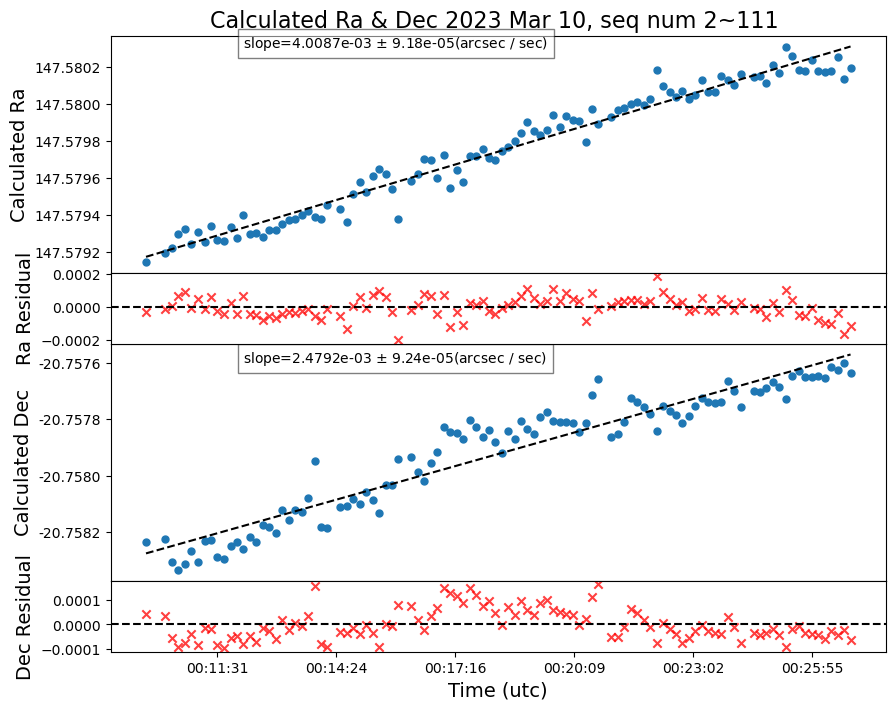

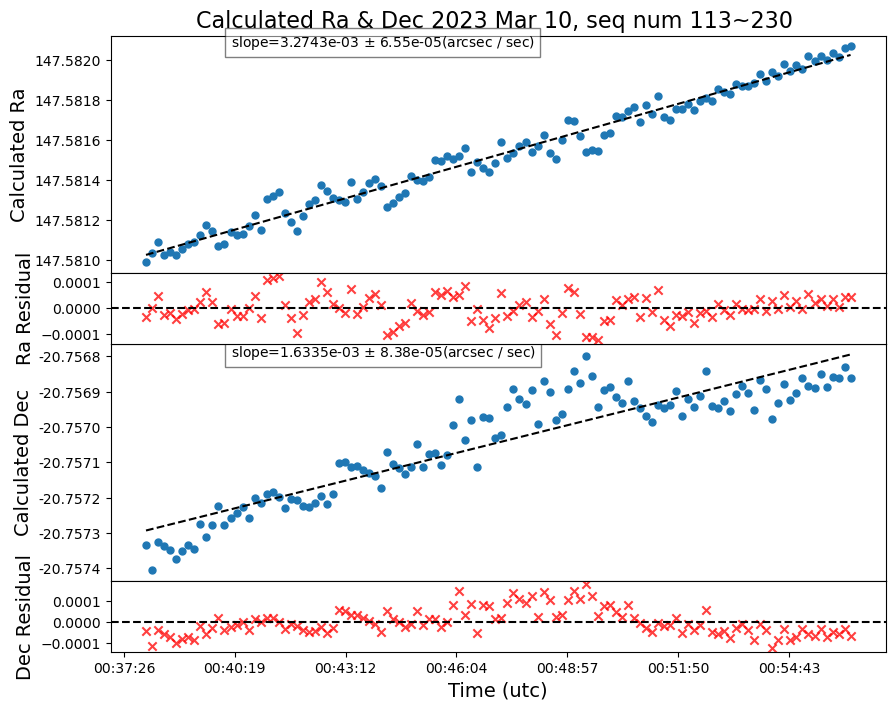

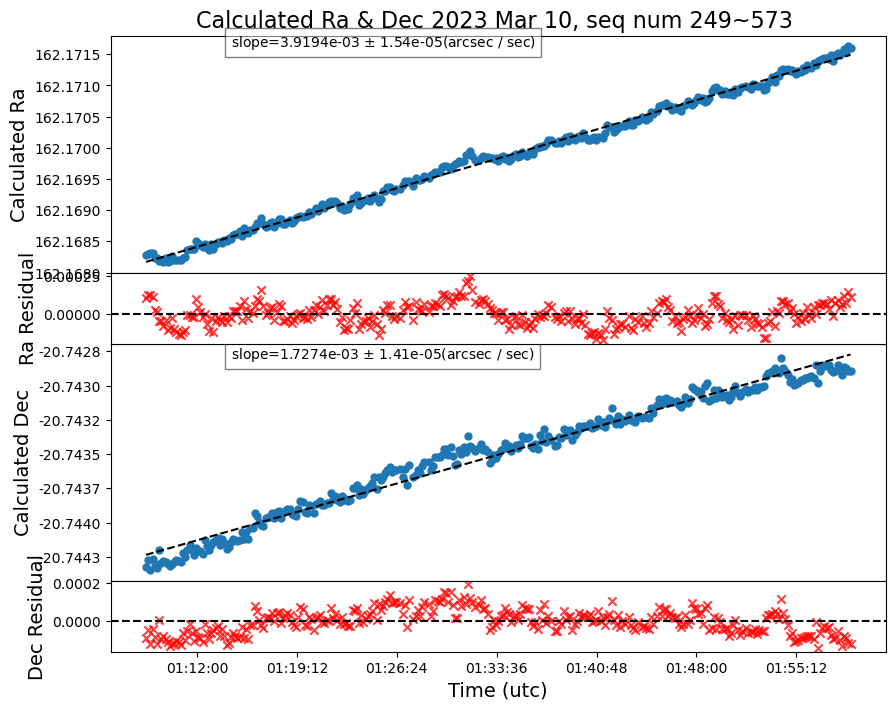

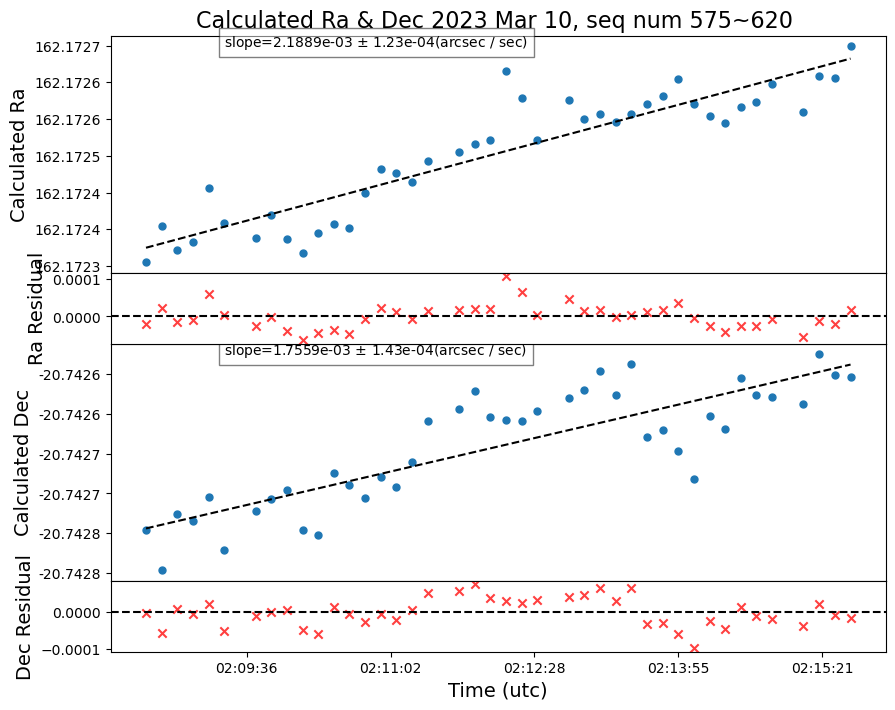

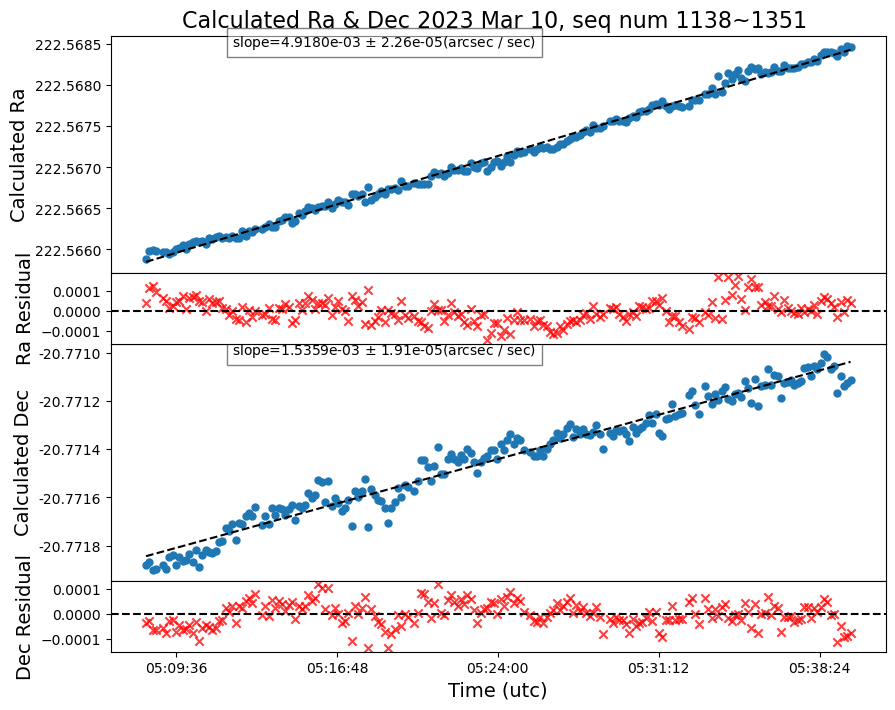

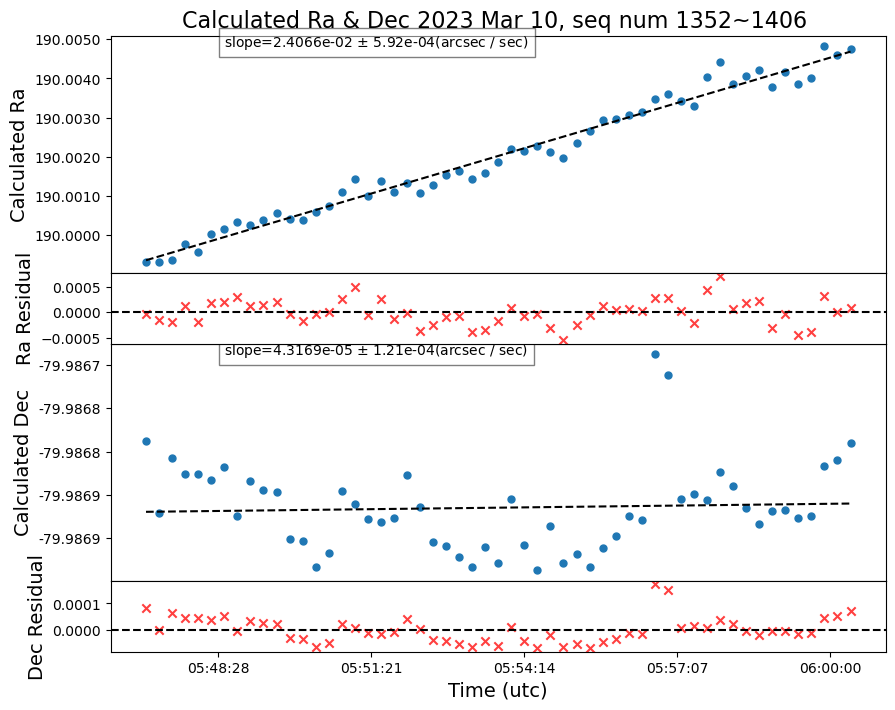

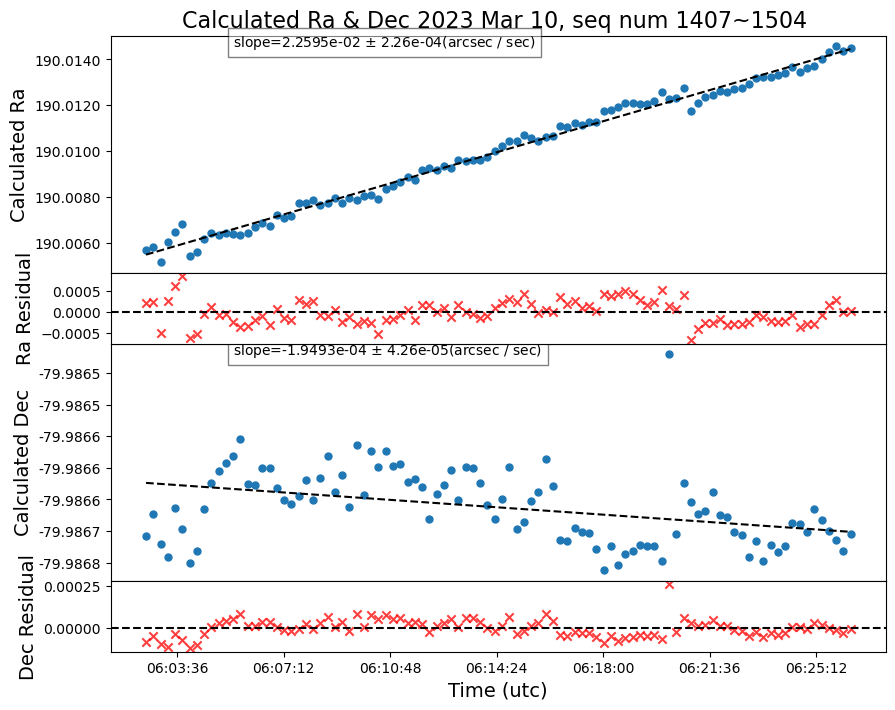

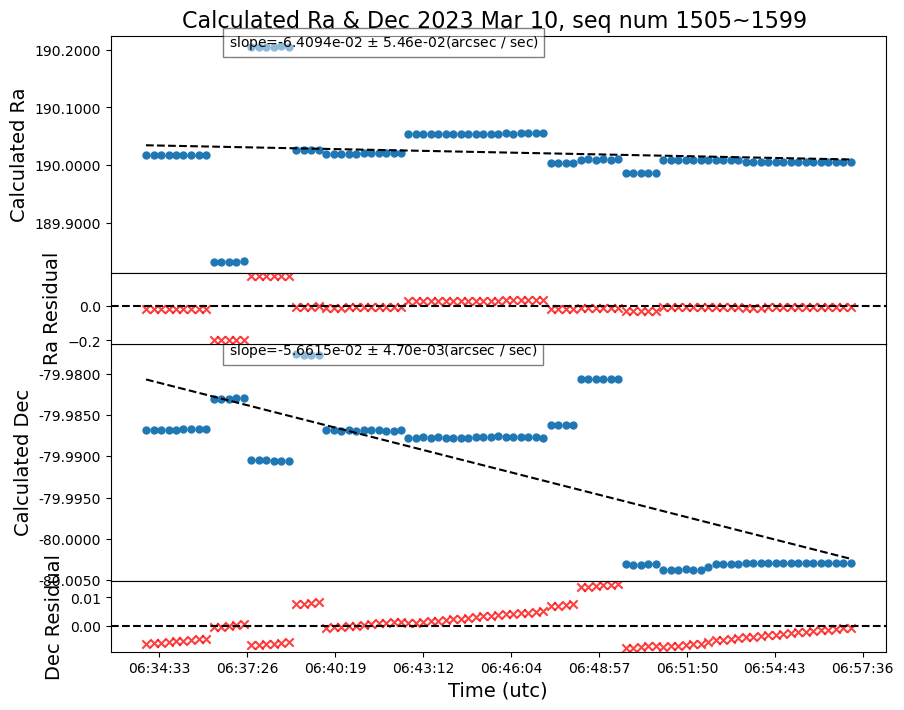

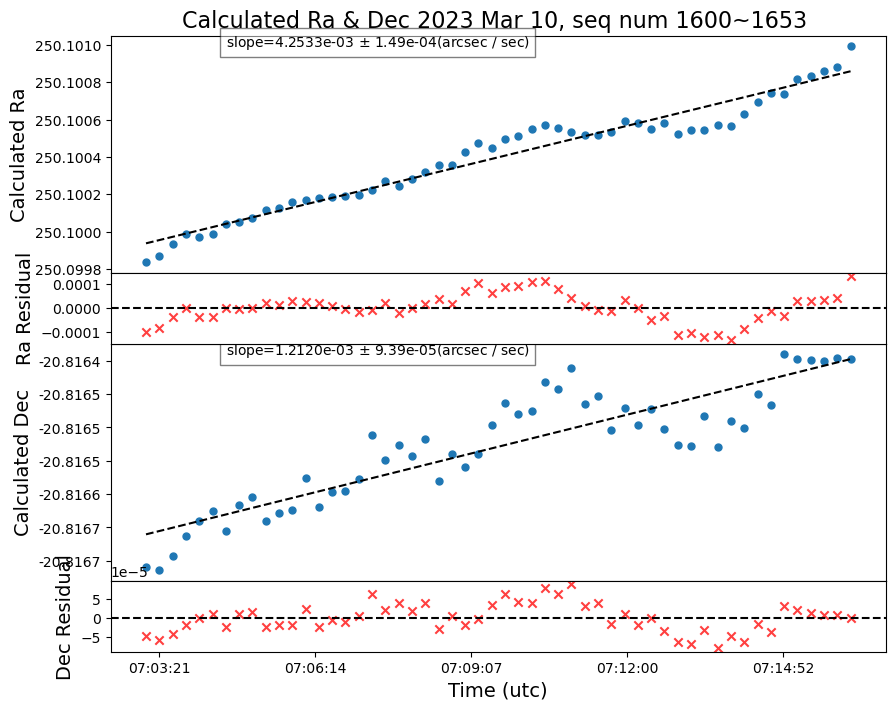

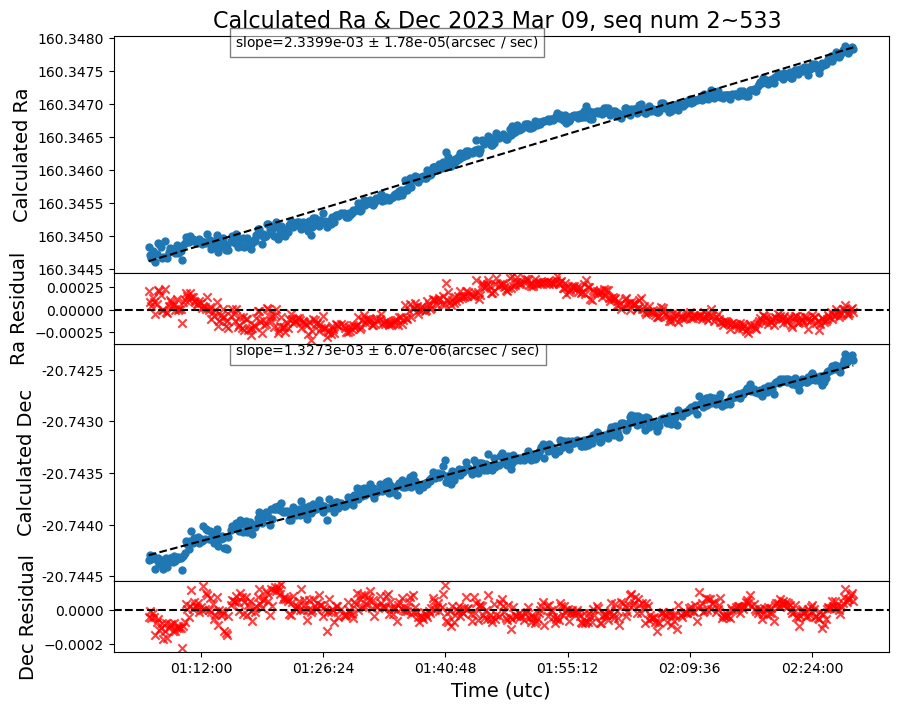

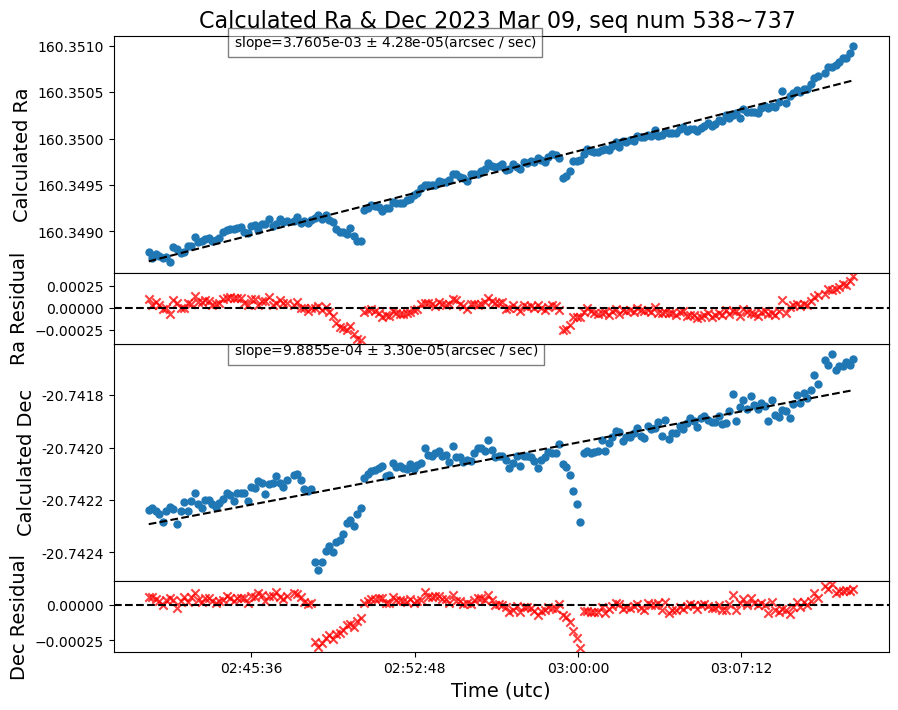

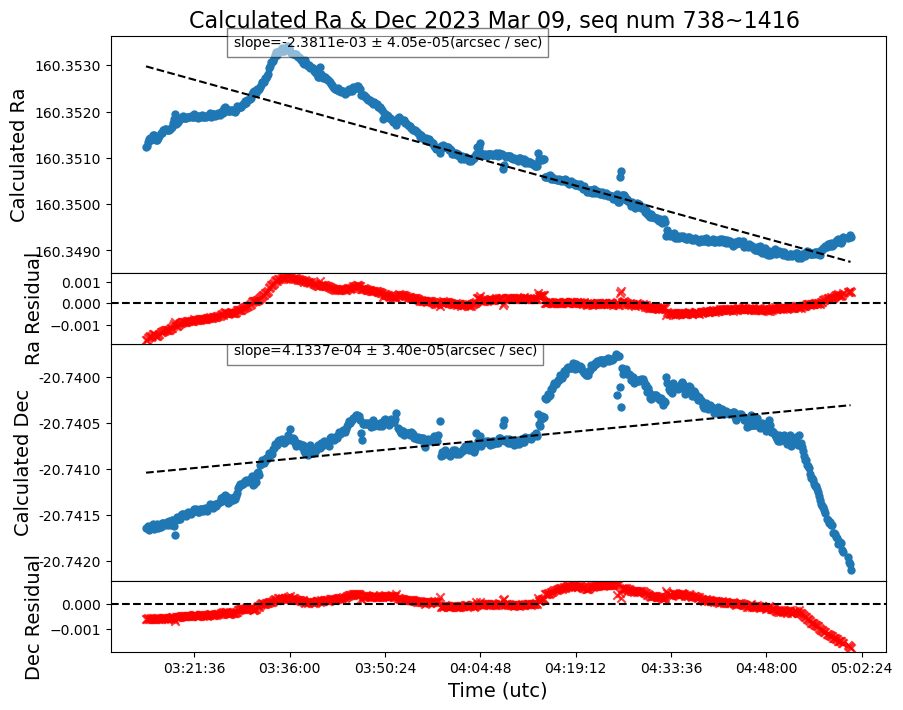

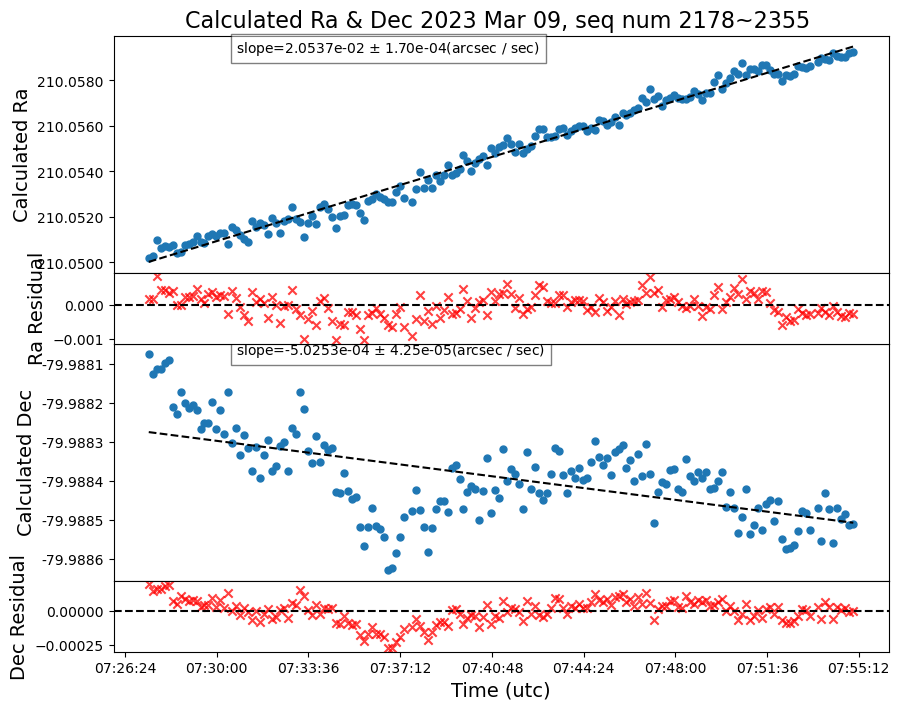

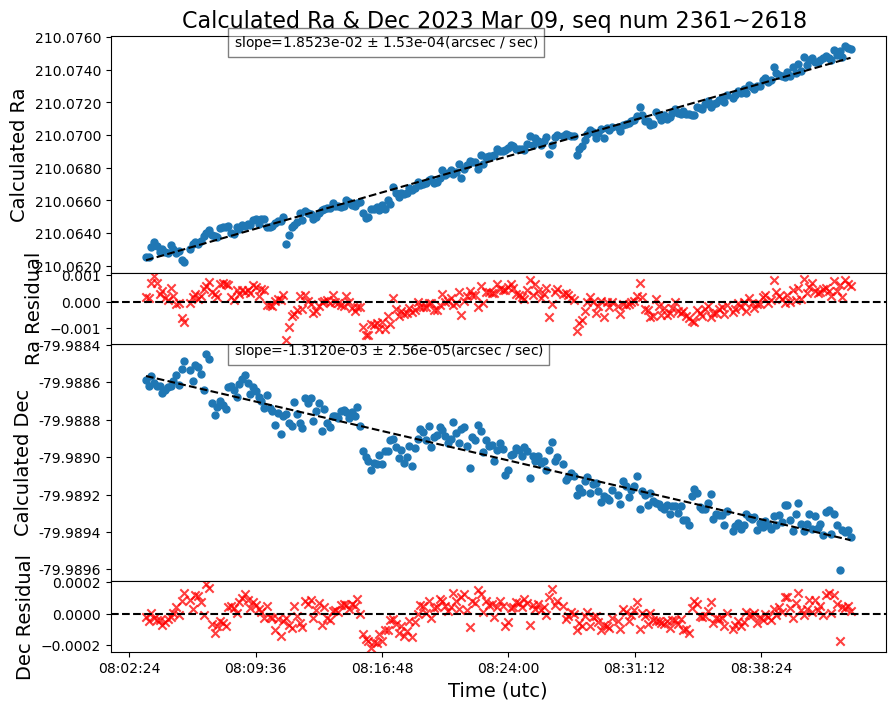

/tmp/ipykernel_3749/479861193.py:82: RuntimeWarning: invalid value encountered in sqrt
  slope_uncertainty_ra = np.sqrt(self.ra_fit_cov[0, 0]) * days_per_sec * arcsec_per_deg
/tmp/ipykernel_3749/479861193.py:84: RuntimeWarning: invalid value encountered in sqrt
  slope_uncertainty_dec = np.sqrt(self.dec_fit_cov[0, 0]) * days_per_sec * arcsec_per_deg


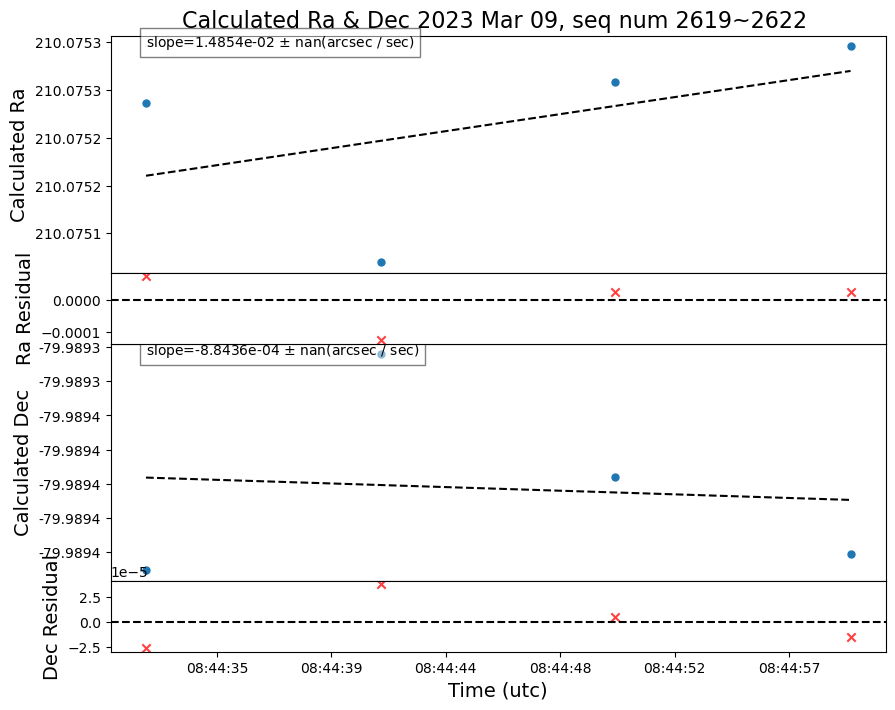

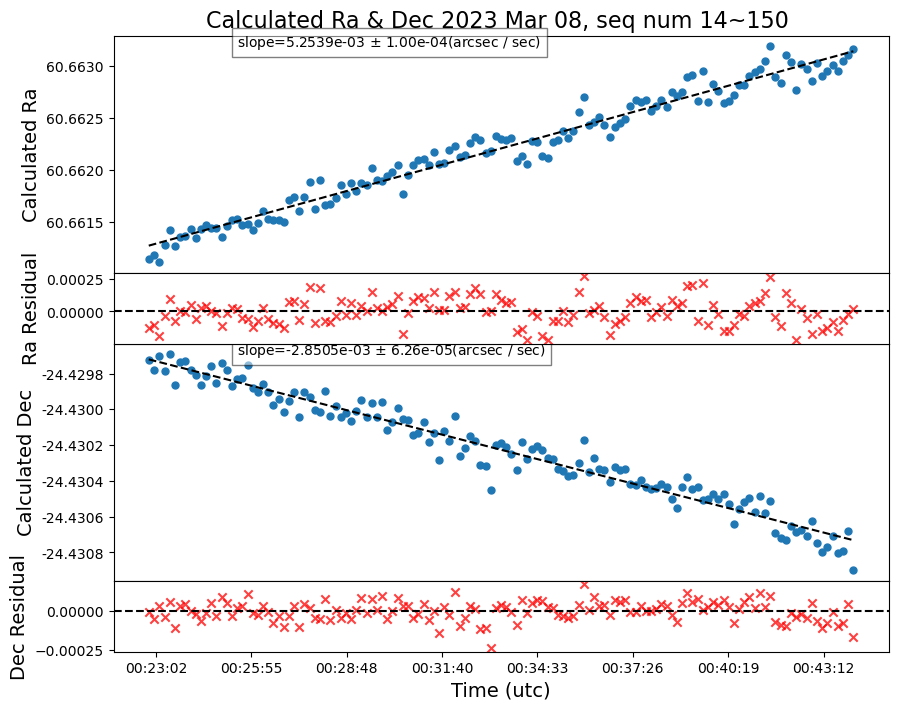

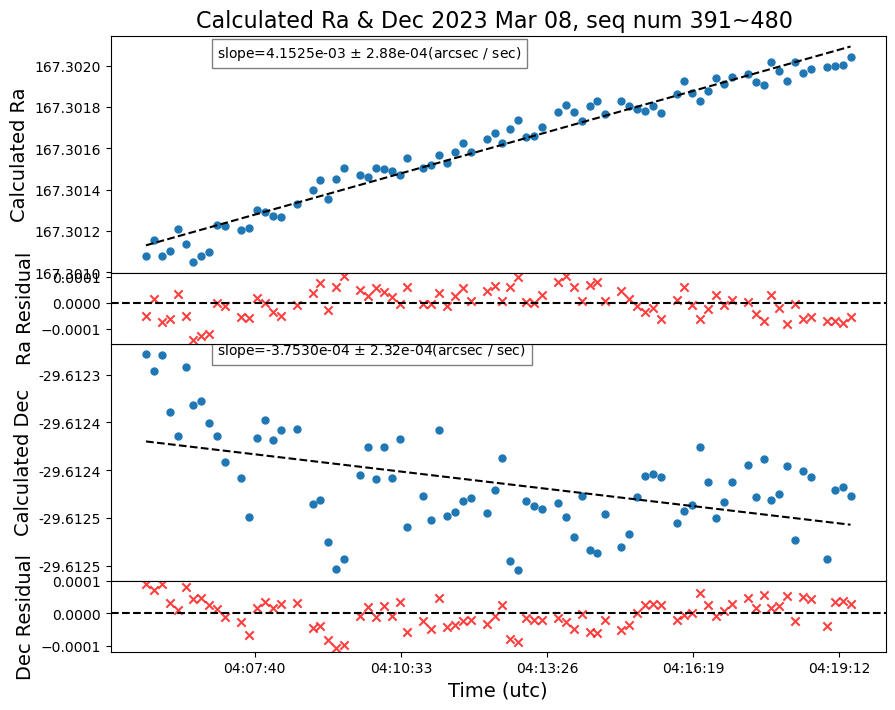

Couldn't analyze sequence range (865, 918). Error message: expected non-empty vector for x. Skipping.
Couldn't analyze sequence range (919, 981). Error message: Singular matrix. Skipping.


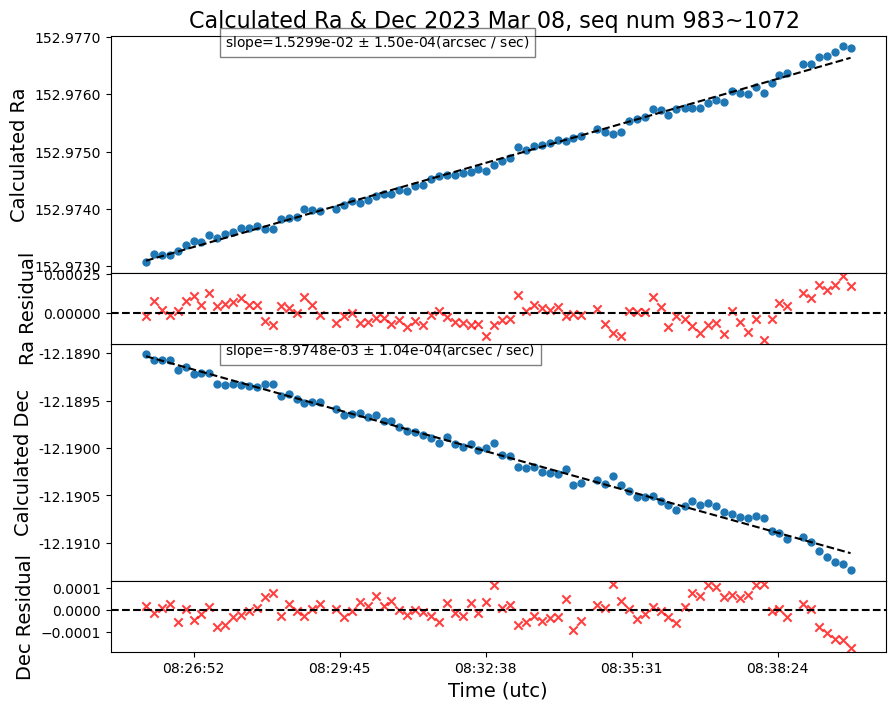

{20230309: array([ 0.0040087 ,  0.00327433,  0.00391942,  0.00218886,  0.00491801,
         0.02406593,  0.02259457, -0.06409418,  0.00425331]),
 20230308: array([ 0.00233989,  0.00376049, -0.00238114,  0.02053666,  0.01852308,
         0.01485395]),
 20230307: array([0.00525391, 0.00415254,        nan,        nan, 0.01529852])}

In [3]:
tracks = {20230309: [(2, 111), (113, 230), (249, 573), (575, 620),
                     (1138, 1351), (1352, 1406), (1407, 1504),
                     (1505, 1599), (1600, 1653)],
          20230308: [(2, 533), (538, 737), (738, 1416), (2178, 2355),
                     (2361, 2618), (2619, 2622)],
          20230307: [(14, 150), (391, 480), (865, 918), (919, 981),
                     (983, 1072)]}

trackingDrift = TrackingDrift(tracks)
trackingDrift.analyze(plot_time_series=True)
trackingDrift.ra_slopes

In [4]:
raDecTS = RaDecTimeSeries()
dayObs = 20230309
raDecTS.set_dayObs(dayObs)
raDecTS.read_table()

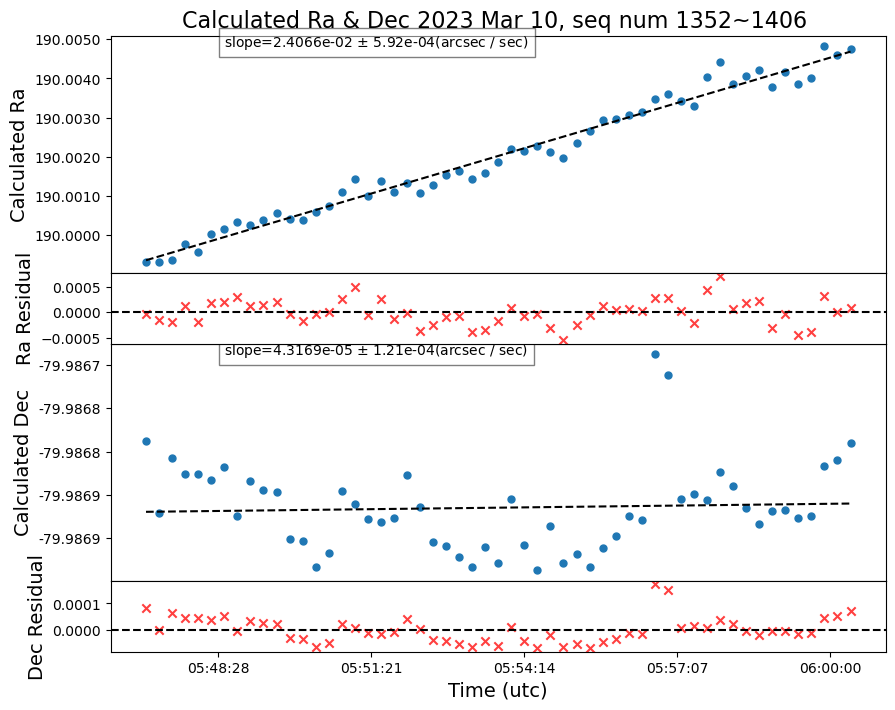

In [5]:
sequenceRange = (1352, 1406)
raDecTS.set_sequence_range(sequenceRange)
raDecTS.analyze()
raDecTS.plot()

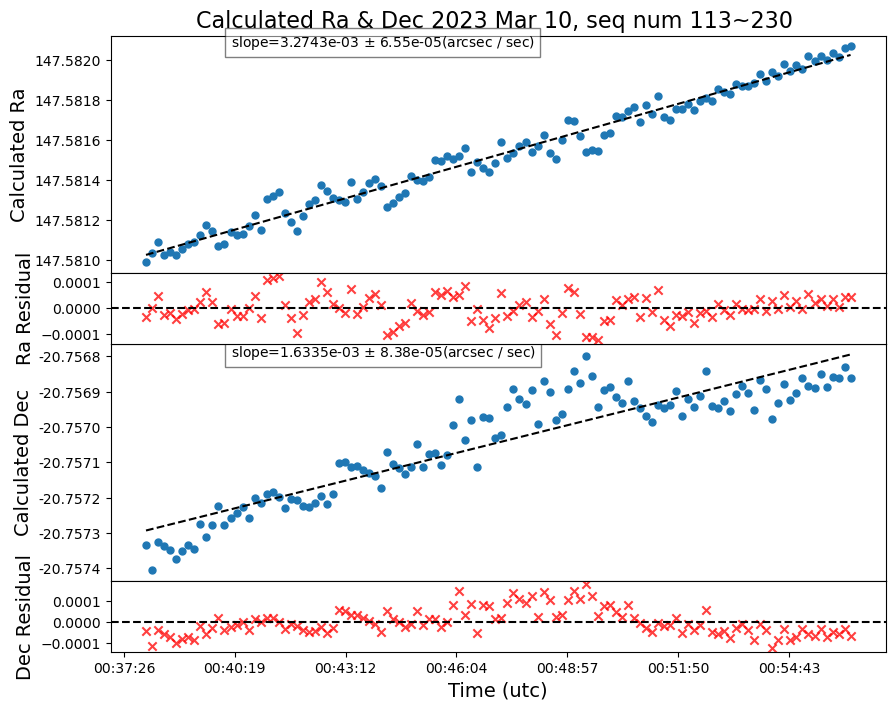

In [6]:
startSequence = 113
endSequence = 230
sequenceRange = (startSequence, endSequence)
raDecTS.set_sequence_range(sequenceRange)
raDecTS.analyze()
raDecTS.plot()

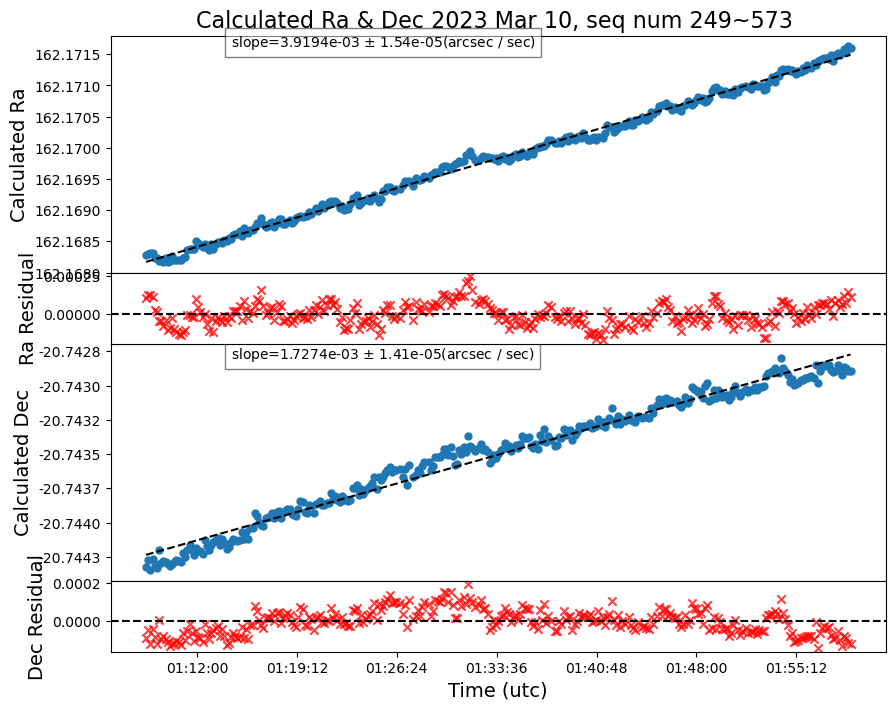

In [7]:
startSequence = 249
endSequence = 573
sequenceRange = (startSequence, endSequence)
raDecTS.set_sequence_range(sequenceRange)
raDecTS.analyze()
raDecTS.plot()